# Generic Data Loaders 

*No frontend for your data?*

**Try a generic data loader!**

*Thinking about writing a new frontend?* 

**Try a generic data loader!** 

Gridded data? Yes! https://yt-project.org/doc/examining/Loading_Generic_Array_Data.html

Particle Data? Yes! https://yt-project.org/doc/examining/Loading_Generic_Particle_Data.html


## `load_uniform_grid`

basic usage:

yt : [INFO     ] 2025-07-15 13:36:18,680 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-15 13:36:18,681 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-07-15 13:36:18,684 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-07-15 13:36:18,685 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-07-15 13:36:18,686 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2025-07-15 13:36:18,793 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-07-15 13:36:18,794 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-07-15 13:36:18,798 xlim = 0.000000 1.000000
yt : [INFO     ] 2025-07-15 13:36:18,799 ylim = 0.000000 1.000000
yt : [INFO     ] 2025-07-15 13:36:18,802 Making a fixed resolution buffer of (('stream', 'field1')) 800 by 800



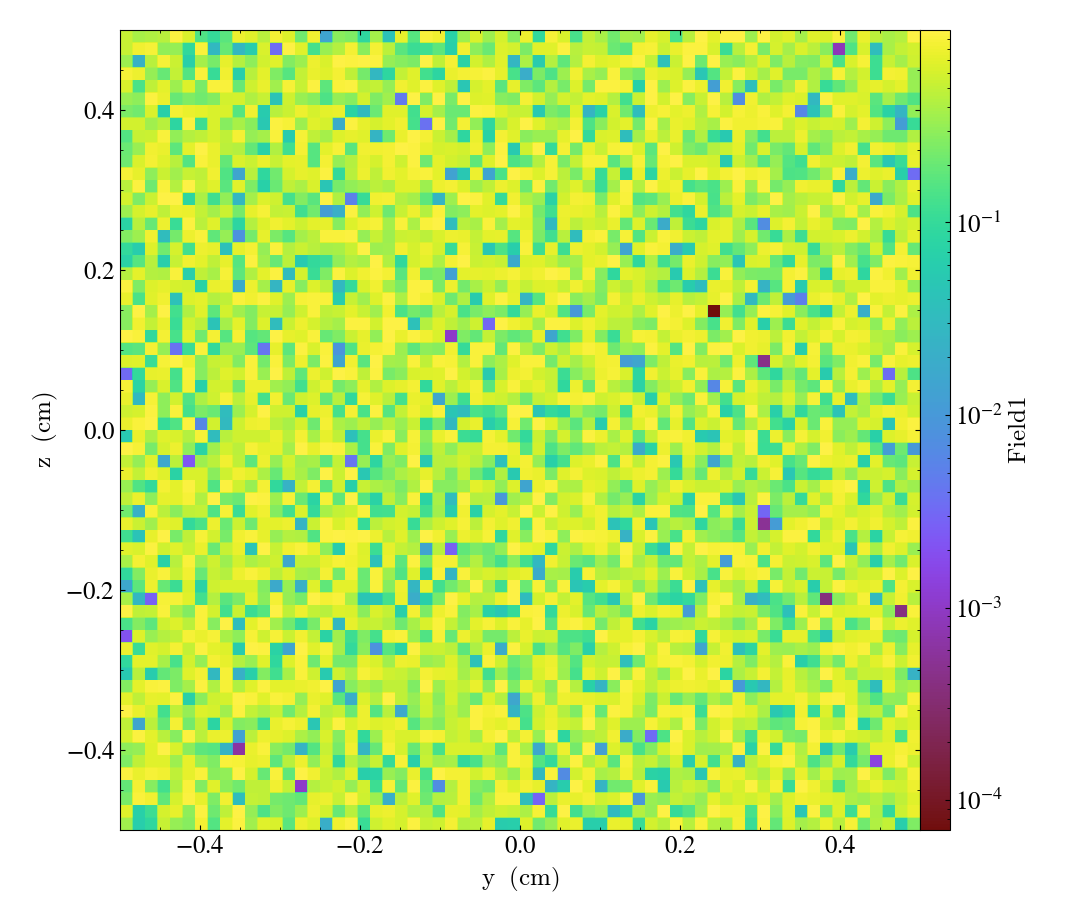

In [3]:
import yt 
import numpy as np
shp = (64, 64, 64)
raw_data = {
    'field1': np.random.random(shp),
}
ds = yt.load_uniform_grid(raw_data, shp)
yt.SlicePlot(ds, 'x', ('stream', 'field1'))

but instead of 

```python
raw_data = {
    'field1': np.random.random(shp),
}
``` 

you can do **anything** 

```python
raw_data = {
    'field1': read_data_from_a_file_or_something('field1'),
}
```

as long as `raw_data['field1']` is a numpy array (or a function! more on this later)

### re-loading a yt dataset as an in-memory uniform grid

All the generic data loaders in yt contain examples in their docstrings: they're basic. they load some numpy arrays. So instead of that, let's create a uniform grid dataset from a standard yt dataset so that we have something interesting to look at! 

So, let's create a fixed-resolution array of a field from `IsolatedGalaxy` -- could do this many ways, `arbitray_grids` are nice and simple (and arbitrary):

In [4]:
import yt
ds = yt.load_sample("IsolatedGalaxy")

# create a grid 25 kpc wide centered on the domain center at some resolution
h_wid = ds.quan(25, 'kpc') / 2
ag = ds.arbitrary_grid(ds.domain_center - h_wid, 
                       ds.domain_center + h_wid, 
                       (512, 512, 512)
                      )

data = {'density': ag['gas', 'density']}

ag.shape, ag.left_edge, ag.right_edge, data['density'].shape

yt : [INFO     ] 2025-07-15 13:36:19,983 Sample dataset found in '/home/chavlin/data/yt_data/yt_sample_sets/IsolatedGalaxy/galaxy0030/galaxy0030'
yt : [INFO     ] 2025-07-15 13:36:20,158 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2025-07-15 13:36:20,159 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2025-07-15 13:36:20,160 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-07-15 13:36:20,161 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-07-15 13:36:20,162 Parameters: cosmological_simulation   = 0
Parsing Hierarchy : 100%|██████████████████| 173/173 [00:00<00:00, 13890.28it/s]
yt : [INFO     ] 2025-07-15 13:36:20,192 Gathering a field list (this may take a moment.)


((512, 512, 512),
 unyt_array([0.48750131, 0.48750131, 0.48750131], 'code_length'),
 unyt_array([0.51249869, 0.51249869, 0.51249869], 'code_length'),
 (512, 512, 512))

now we have a data array as a plain numpy array (in memory), let's pretend we don't know where this data came... and let's say we want to load it into yt. It's a fixed array, so `yt.load_uniform_grid` is the way to go. 

Check the docstring and give it a try:

In [5]:
yt.load_uniform_grid?

Signature:
yt.load_uniform_grid(
    data,
    domain_dimensions,
    length_unit=None,
    bbox=None,
    nprocs=1,
    sim_time=0.0,
    mass_unit=None,
    time_unit=None,
    velocity_unit=None,
    magnetic_unit=None,
    periodicity=(True, True, True),
    geometry='cartesian',
    unit_system='cgs',
    default_species_fields=None,
    *,
    axis_order: tuple[str, str, str] | None = None,
    cell_widths=None,
    parameters=None,
    dataset_name: str = 'UniformGridData',
)
Docstring:
Load a uniform grid of data into yt as a
:class:`~yt.frontends.stream.data_structures.StreamHandler`.

This should allow a uniform grid of data to be loaded directly into yt and
analyzed as would any others.  This comes with several caveats:

* Units will be incorrect unless the unit system is explicitly
  specified.
* Some functions may behave oddly, and parallelism will be
  disappointing or non-existent in most cases.
* Particles may be difficult to integrate.

Particle fields are detected as 

One quick hint/gotchya though: you want to supply a bounding box. But because datasets have unyt arrays and quantities 

In [6]:
length_unit = 'kpc' # use this for the load_uniform_grid length_unit keyword argument

# and use the following to construct a bounding box to supply to the bbox keyword argument
left_edge = ag.left_edge.to(length_unit).d
right_edge = ag.right_edge.to(length_unit).d

Ok, go load your uniform grid:

In [7]:
bbox = np.column_stack([ag.left_edge, ag.right_edge]).to('kpc').d
bbox

array([[487.55224445, 512.55224445],
       [487.55224445, 512.55224445],
       [487.55224445, 512.55224445]])

In [8]:
ds_in_mem = yt.load_uniform_grid(data, ag.shape, bbox=bbox, length_unit='kpc')

yt : [INFO     ] 2025-07-15 13:36:22,695 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-15 13:36:22,696 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2025-07-15 13:36:22,696 Parameters: domain_left_edge          = [487.55224445 487.55224445 487.55224445]
yt : [INFO     ] 2025-07-15 13:36:22,697 Parameters: domain_right_edge         = [512.55224445 512.55224445 512.55224445]
yt : [INFO     ] 2025-07-15 13:36:22,698 Parameters: cosmological_simulation   = 0


Check what fields we have (note the default field type that gets added):

In [9]:
ds_in_mem.field_list

[('stream', 'density')]

and do something with it (I dunno, a SlicePlot?):

yt : [INFO     ] 2025-07-15 13:36:22,923 xlim = 487.552244 512.552244
yt : [INFO     ] 2025-07-15 13:36:22,924 ylim = 487.552244 512.552244
yt : [INFO     ] 2025-07-15 13:36:22,927 xlim = 487.552244 512.552244
yt : [INFO     ] 2025-07-15 13:36:22,927 ylim = 487.552244 512.552244
yt : [INFO     ] 2025-07-15 13:36:22,929 Making a fixed resolution buffer of (('stream', 'density')) 800 by 800



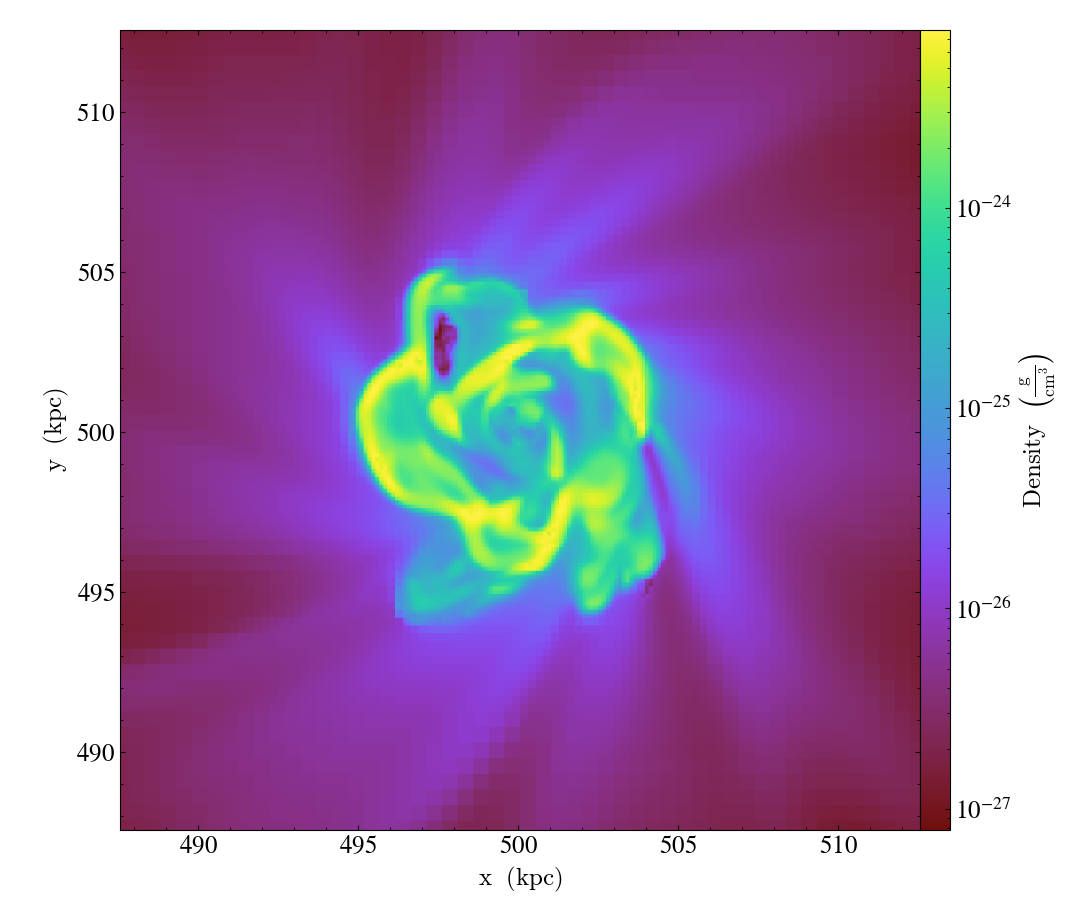

In [10]:
yt.SlicePlot(ds_in_mem, 'z', ('stream', 'density'), origin='native')

yay! on to more interesting stuff...

### `load_uniform_grid` with on demand data-loading via functions

If you read the whole docstring, maybe you caught the entry for the `data` argument:

```
data : dict
    This is a dict of numpy arrays, (numpy array, unit spec) tuples.
    Functions may also be supplied in place of numpy arrays as long as the
    subsequent argument nprocs is not specified to be greater than 1.
    Supplied functions much accepts the arguments (grid_object, field_name)
    and return numpy arrays.  The keys to the dict are the field names.
```


This bit: **`Functions may also be supplied in place of numpy arrays`**

Let's explore that...

By wrapping our full yt dataset with a lazy-evaluation of an arbitrary grid for all of the fields that exist in the original dataset! That sounds fun. 

So what do we need for a function? That docstring entry is maybe a little opaque...

Here's an outline: 

```python

ds = yt.load() # our full dataset! 

def load_field_from_ag(grid_object, field_tuple):

    # get the extent and shape of the grid_object
    le = # left edge of the grid object
    re = # right edge of the grid object
    shape = # shape of the grid object 

    # construct an abritrary grid on the **full** dataset
    ag = ds.arbitrary_grid(le, re, shape)

    # evaluate the field on the arbitrary grid of the full dataset 
    fixed_res_array = ag[field_tuple].d  # make it a plain numpy array with the .d
    return fixed_res_array
```

What this does in words is inject a handle to our full yt dataset within a function that can evaluate a field on a grid coming from somewhere else (our wrapping dataset). 

And when building our field dictionary for `load_uniform_grid`, we supply this function instead of a numpy array:

```python
data = {'density': load_field_from_ag,}

ds_wrapper = yt.load_uniform_grid(data, data_shape, ....)
```

and when yt goes to fetch data for the grid, the arbitrary grid will be evalulated on demand. 

Ok, so let's try to actually implement this...

First, let's understand a bit more about what this incoming `grid_object` argument will look like by looking at one of the grids of our base dataset: 

In [11]:
g0 = ds.index.grids[0]
g0

EnzoGrid_0001 ([32 32 32])

from which we can extract the extent and shape of that grid:

In [12]:
g0.LeftEdge, g0.RightEdge, g0.shape

(unyt_array([0., 0., 0.], 'code_length'),
 unyt_array([1., 1., 1.], 'code_length'),
 array([32, 32, 32], dtype=int32))

ok, so let's think about the `field_tuple` argument a bit too. This will be actually be a tuple of field type and field name:

```python
field_tuple = (field_type, actual_field_name)
```

there are some slightly finicky behaviors related to field types and the generic data loaders... most will end up with a field type called `'stream'`, and due to **reasons**, we can't use the raw field types from our primary dataset. So what we'll do in our function is replace the incoming `'stream'` fieldtype with `'enzo'` in our function:


```python
def load_field_from_ag(grid_object, field_tuple):

    # get the extent and shape of the grid_object
    le = # left edge of the grid object
    re = # right edge of the grid object
    shape = # shape of the grid object 

    # construct an abritrary grid on the **full** dataset
    ag = ds.arbitrary_grid(le, re, shape)

    # evaluate the field on the arbitrary grid of the full dataset 
    ds_field_tuple = ('enzo', field_tuple[1])
    fixed_res_array = ag[ds_field_tuple].d  # make it a plain numpy array with the .d
    return fixed_res_array
```    

Ooooook, go ahead and fill in the rest now:

In [13]:
def load_field_from_ag(grid_object, field_name):
    # get the extent and shape of the grid_object
    le = grid_object.LeftEdge  # left edge of the grid object
    re = grid_object.RightEdge # right edge of the grid object 
    shape = grid_object.shape # shape of the grid object 

    # construct an abritrary grid on the **full** dataset    
    ag = ds.arbitrary_grid(le, re, shape)

    # evaluate the field on the arbitrary grid of the full dataset 
    # full_ds_field_name = field_name_map[field_name[1]]  # annoying.    
    full_ds_field_name = ('enzo', field_name[1]) # replace     
    fixed_res_array = ag[full_ds_field_name].d  # make it a plain numpy array with the .d
    return fixed_res_array

and let's build our field dictionary, keeping only the `'enzo'` field type fields:

In [14]:
data = {}

for field in ds.field_list:    
    if field[0] == 'enzo':
        data[field[1]] = load_field_from_ag

data.keys()

dict_keys(['Average_creation_time', 'Bx', 'By', 'Bz', 'Cooling_Time', 'Dark_Matter_Density', 'Density', 'Electron_Density', 'Forming_Stellar_Mass_Density', 'Galaxy1Colour', 'Galaxy2Colour', 'HII_Density', 'HI_Density', 'HeIII_Density', 'HeII_Density', 'HeI_Density', 'MBHColour', 'Metal_Density', 'PhiField', 'Phi_pField', 'SFR_Density', 'Star_Particle_Density', 'Temperature', 'TotalEnergy', 'gammaHI', 'kphHI', 'kphHeI', 'kphHeII', 'x-velocity', 'y-velocity', 'z-velocity'])

In [15]:
arbitrary_shape = (256, 256, 256)
arbitrary_bbox = np.array([[.48, .52], 
                           [.48, .52],
                           [.48, .52]])

ds_delayed = yt.load_uniform_grid(data, arbitrary_shape, bbox=arbitrary_bbox, length_unit='Mpc')

yt : [INFO     ] 2025-07-15 13:36:26,643 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-15 13:36:26,643 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-07-15 13:36:26,644 Parameters: domain_left_edge          = [0.48 0.48 0.48]
yt : [INFO     ] 2025-07-15 13:36:26,645 Parameters: domain_right_edge         = [0.52 0.52 0.52]
yt : [INFO     ] 2025-07-15 13:36:26,646 Parameters: cosmological_simulation   = 0


In [16]:
ds_delayed.field_list

[('stream', 'Average_creation_time'),
 ('stream', 'Bx'),
 ('stream', 'By'),
 ('stream', 'Bz'),
 ('stream', 'Cooling_Time'),
 ('stream', 'Dark_Matter_Density'),
 ('stream', 'Density'),
 ('stream', 'Electron_Density'),
 ('stream', 'Forming_Stellar_Mass_Density'),
 ('stream', 'Galaxy1Colour'),
 ('stream', 'Galaxy2Colour'),
 ('stream', 'HII_Density'),
 ('stream', 'HI_Density'),
 ('stream', 'HeIII_Density'),
 ('stream', 'HeII_Density'),
 ('stream', 'HeI_Density'),
 ('stream', 'MBHColour'),
 ('stream', 'Metal_Density'),
 ('stream', 'PhiField'),
 ('stream', 'Phi_pField'),
 ('stream', 'SFR_Density'),
 ('stream', 'Star_Particle_Density'),
 ('stream', 'Temperature'),
 ('stream', 'TotalEnergy'),
 ('stream', 'gammaHI'),
 ('stream', 'kphHI'),
 ('stream', 'kphHeI'),
 ('stream', 'kphHeII'),
 ('stream', 'x-velocity'),
 ('stream', 'y-velocity'),
 ('stream', 'z-velocity')]

yt : [INFO     ] 2025-07-15 13:36:28,158 xlim = 0.480000 0.520000
yt : [INFO     ] 2025-07-15 13:36:28,158 ylim = 0.480000 0.520000
yt : [INFO     ] 2025-07-15 13:36:28,161 xlim = 0.479950 0.519946
yt : [INFO     ] 2025-07-15 13:36:28,162 ylim = 0.479950 0.519946
yt : [INFO     ] 2025-07-15 13:36:28,164 Making a fixed resolution buffer of (('stream', 'Density')) 800 by 800



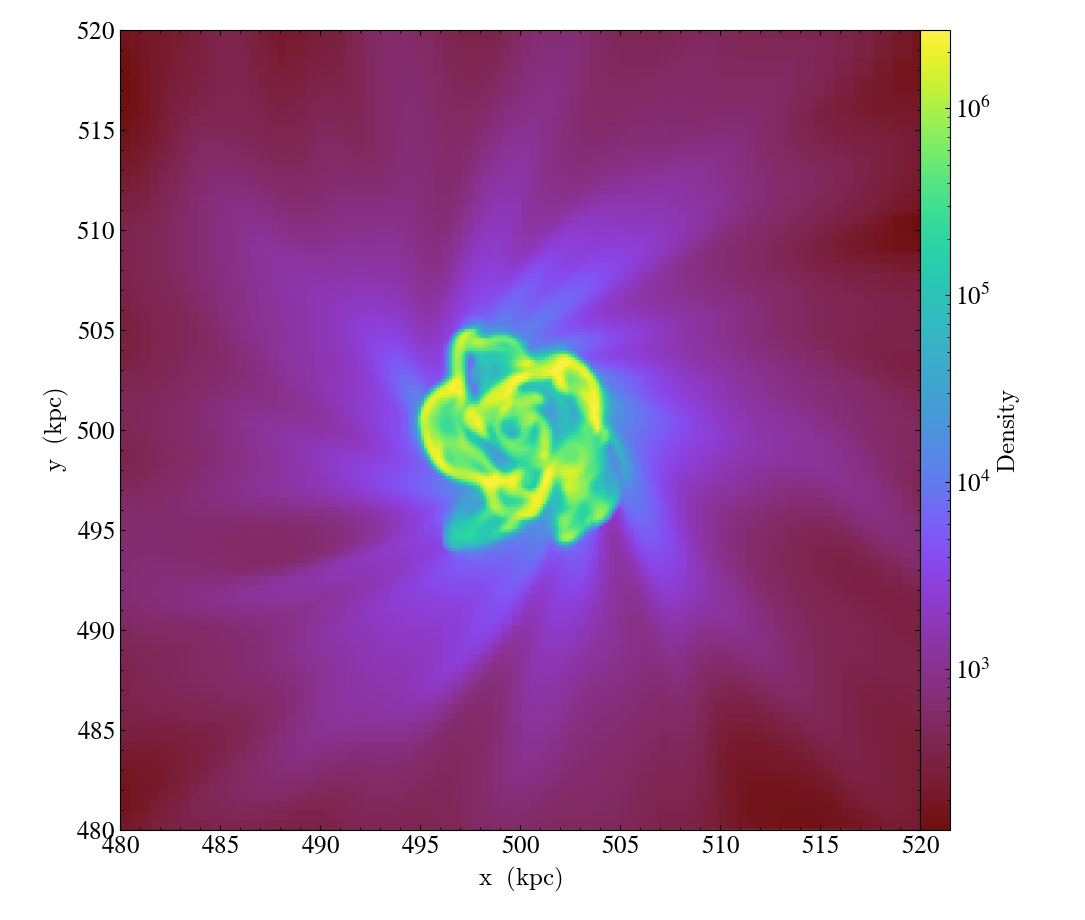

In [17]:
yt.SlicePlot(ds_delayed, 'z', ('stream', 'Density'), origin='native')

In [18]:
ds.domain_right_edge.to('Mpc')

unyt_array([1.00010449, 1.00010449, 1.00010449], 'Mpc')

yt : [INFO     ] 2025-07-15 13:36:29,931 xlim = 0.479950 0.519946
yt : [INFO     ] 2025-07-15 13:36:29,932 ylim = 0.479950 0.519946
yt : [INFO     ] 2025-07-15 13:36:29,935 xlim = 0.479845 0.519841
yt : [INFO     ] 2025-07-15 13:36:29,936 ylim = 0.479845 0.519841
yt : [INFO     ] 2025-07-15 13:36:29,937 Making a fixed resolution buffer of (('stream', 'Density')) 800 by 800



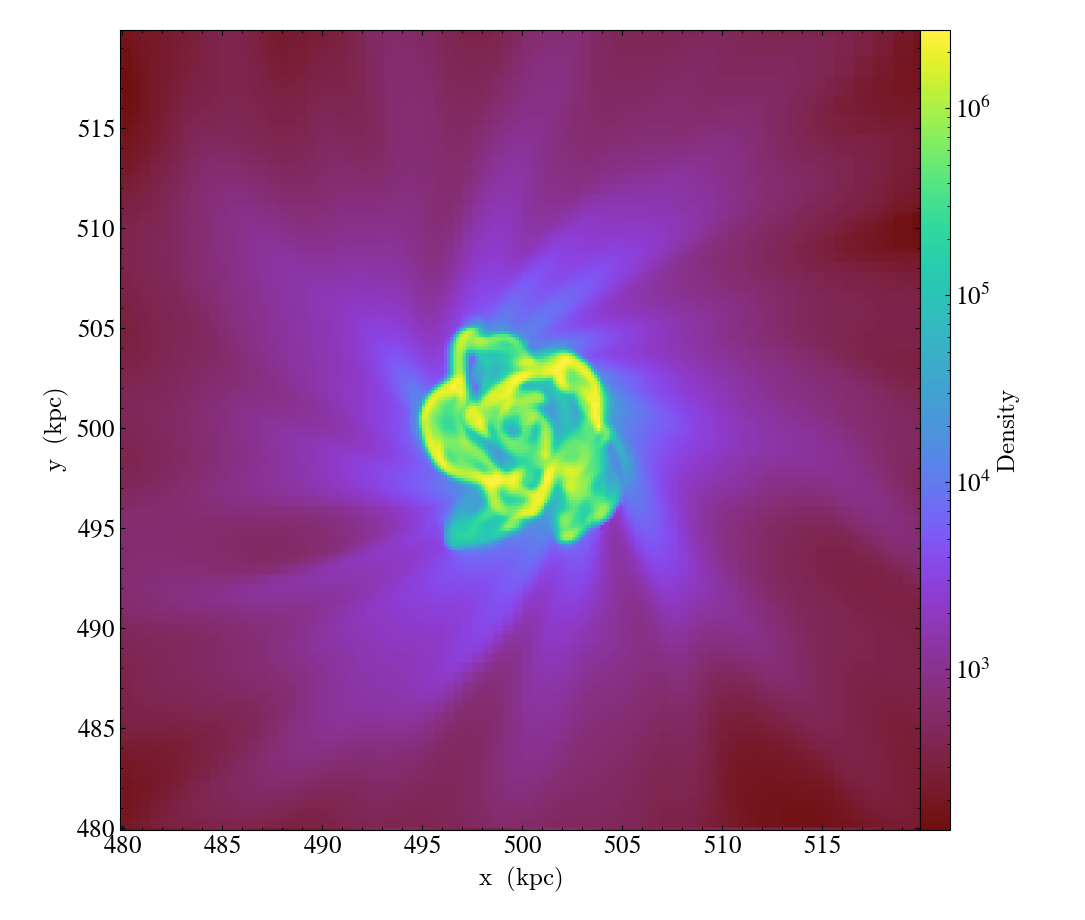

In [19]:
yt.SlicePlot(ds_delayed, 'z', ('stream', 'Density'), origin='native')

yt : [INFO     ] 2025-07-15 13:36:32,287 xlim = 0.479950 0.519946
yt : [INFO     ] 2025-07-15 13:36:32,288 ylim = 0.479950 0.519946
yt : [INFO     ] 2025-07-15 13:36:32,290 xlim = 0.479845 0.519841
yt : [INFO     ] 2025-07-15 13:36:32,291 ylim = 0.479845 0.519841
yt : [INFO     ] 2025-07-15 13:36:32,293 Making a fixed resolution buffer of (('stream', 'Temperature')) 800 by 800



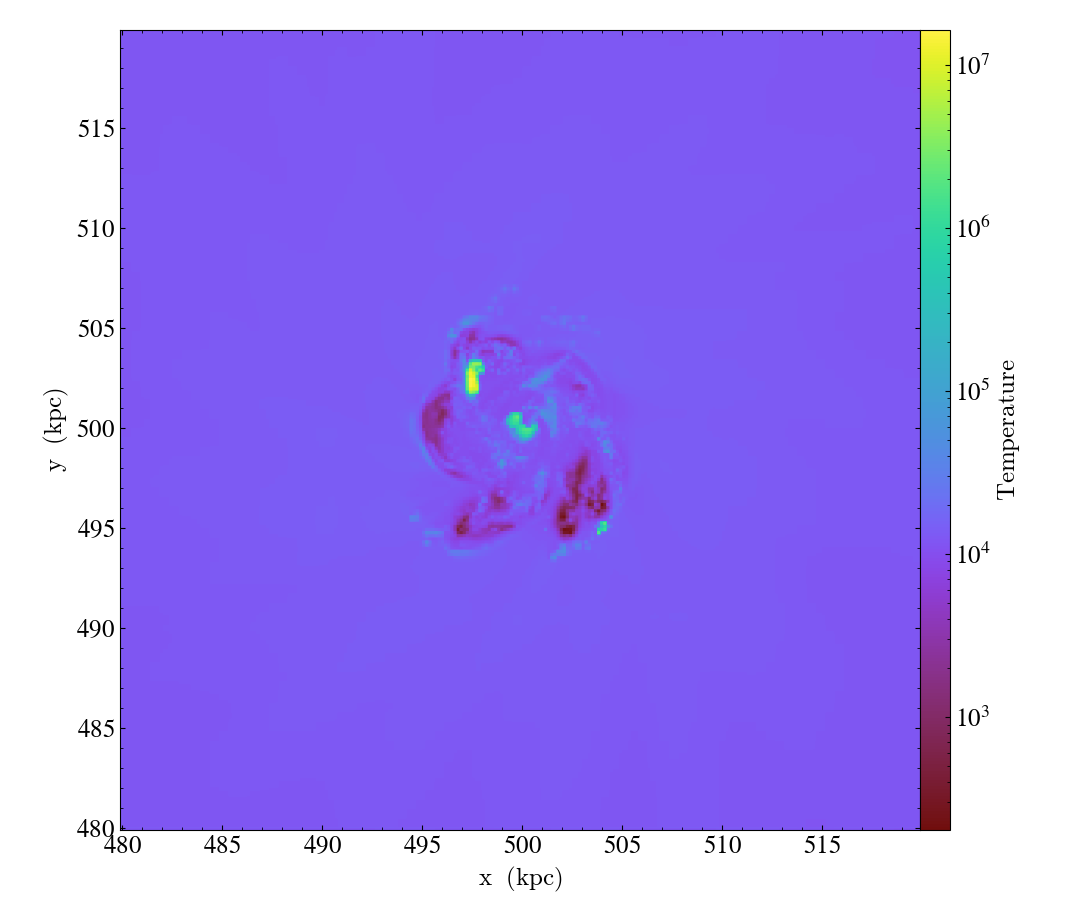

In [20]:
yt.SlicePlot(ds_delayed, 'z', ('stream', 'Temperature'), origin='native')

Ok... but why??

The `ds` reference in:

```python
def load_field_from_ag(grid_object, field_name):

    # grid_object is for the wrapping dataset
    le = ds.arr(grid_object.LeftEdge.to('kpc').d, 'kpc')
    re = ds.arr(grid_object.RightEdge.to('kpc').d, 'kpc')
    shape = grid_object.shape

    
    ag = ds.arbitrary_grid(le, re, shape)

    print(le, re, shape)
    
    return ag[field_name_map[field_name[1]]].d
```

Could be anything! 

* handle to an open h5py file (`yt.load_hdf5_file`)
* handle to an open xarray dataset (`yt_xarray`)
* a dask array
* a zarr store
* ......

`load_amr_grids` **also accepts functions** for loading, so you can, e.g., map chunks of a dask or zarr array to yt grid objects to handle larger-than-memory datasets.

## `load_amr_grids` 

The following example builds a block-AMR grid by recursively dividing a bounding grid by 2 at each level and populating data at each level. 

For each level, there is a single grid, defined by a grid dictionary object of the form:

```python
grid = {
        "left_edge": le_i,
        "right_edge": re_i,
        "dimensions": sz_i,
        "level": lev,
        ("stream", "density"): levp1_noisy,
        ("stream", "lev_p1"): levp1,
    }
```

* `left_edge` and `right_edge`: the 3D left/right corners of the grid
* `dimensions`: the shape of the grid
* `level`: the refinement level
* `("stream", "density")` and `("stream", "lev_p1")` some data fields so we can plot


In [22]:
# set our global bounding box
bbox = np.array([[-1., 1.], 
                 [-1., 1.], 
                 [-1., 1.]])

# size of the coarsest grid (level 0)
sz_0 = np.array((64, 64, 64))

# max refinement levels
max_lev = 4

# calculate box width, box center, grid spacing for level 0
bbox_wid = bbox[:, 1] - bbox[:, 0]
bbox_c = np.mean(bbox, axis=1)
dd0 = bbox_wid / sz_0

# iterate over grid levels
sz_i = sz_0.copy()
grids = []  # container for each grid dictionary
for lev in range(max_lev):

    # calculate the current grid's bounding box width
    box_wid_factor = 2.0 * int(lev > 0) + int(lev == 0) * 1.0
    bbox_wid = bbox_wid / box_wid_factor

    # calculate the left/right edges
    le_i = bbox_c - bbox_wid / 2.0
    re_i = bbox_c + bbox_wid / 2.0

    # find closest start/end index in lev 0 grid
    start_i = np.round(le_i / dd0).astype(int)
    end_i = np.round(re_i / dd0).astype(int)
    sz_0 = end_i - start_i

    # recompute for rounding errors (watch out!)
    le_i = start_i * dd0
    re_i = le_i + sz_0 * dd0

    # the size of the current level
    sz_i = sz_0 * 2**lev

    # calculate some fields for this level
    levp1 = np.full(sz_i, lev + 1.0)
    levp1_noisy = levp1 + np.random.random(sz_i) - 0.5

    # define the grid dictionary
    grid = {
        "left_edge": le_i,
        "right_edge": re_i,
        "dimensions": sz_i,
        "level": lev,
        ("stream", "lev_p1_noisy"): levp1_noisy,
        ("stream", "lev_p1"): levp1,
    }
    grids.append(grid)

ds = yt.load_amr_grids(
    grids,
    sz_0,
    bbox=bbox,
    length_unit='m',    
)

yt : [INFO     ] 2025-07-15 13:36:45,664 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-07-15 13:36:45,665 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2025-07-15 13:36:45,666 Parameters: domain_left_edge          = [-1. -1. -1.]
yt : [INFO     ] 2025-07-15 13:36:45,666 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-07-15 13:36:45,667 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2025-07-15 13:37:07,248 xlim = -1.000000 1.000000
yt : [INFO     ] 2025-07-15 13:37:07,249 ylim = -1.000000 1.000000
yt : [INFO     ] 2025-07-15 13:37:07,252 xlim = -1.000000 1.000000
yt : [INFO     ] 2025-07-15 13:37:07,253 ylim = -1.000000 1.000000
yt : [INFO     ] 2025-07-15 13:37:07,256 Making a fixed resolution buffer of (('stream', 'lev_p1_noisy')) 800 by 800



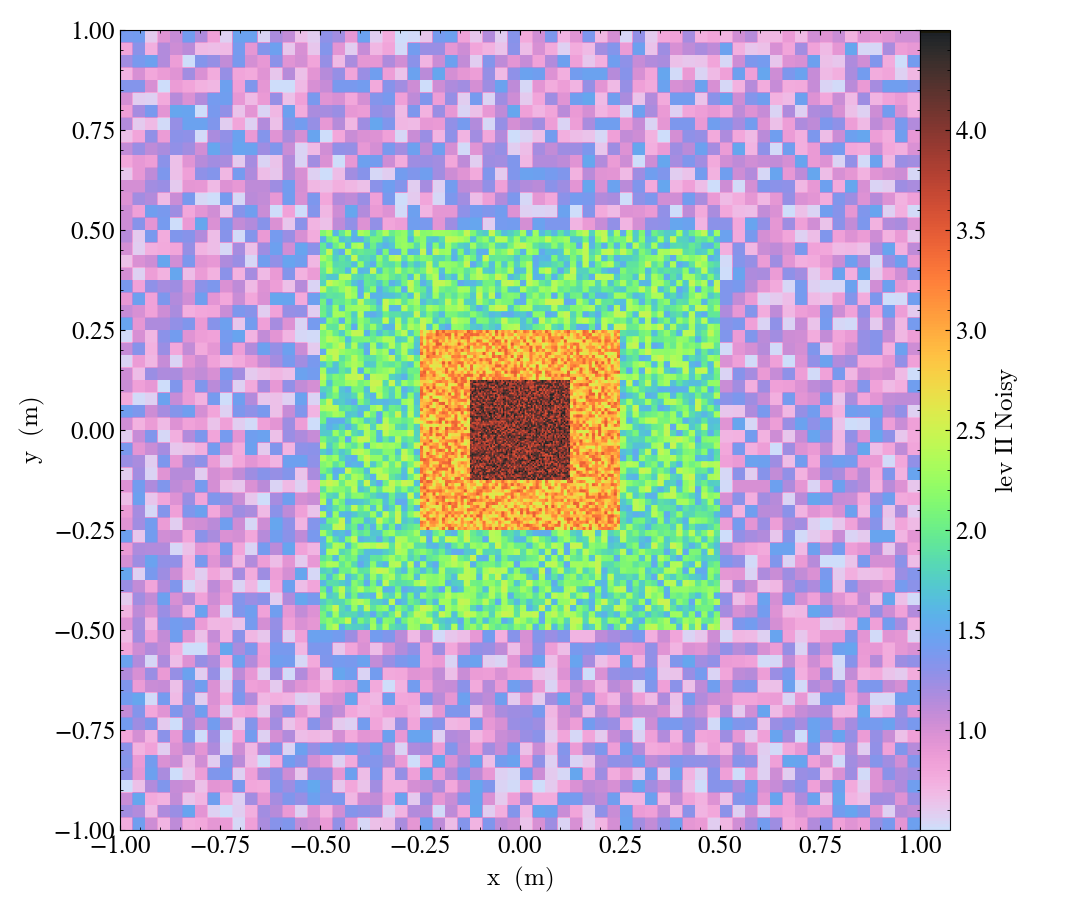

In [24]:
slc = yt.SlicePlot(ds, 'z', ('stream', 'lev_p1_noisy'))
slc.set_log(('stream', 'lev_p1_noisy'), False)
slc.set_cmap(('stream', 'lev_p1_noisy'), 'cmyt.pastel_r')
slc


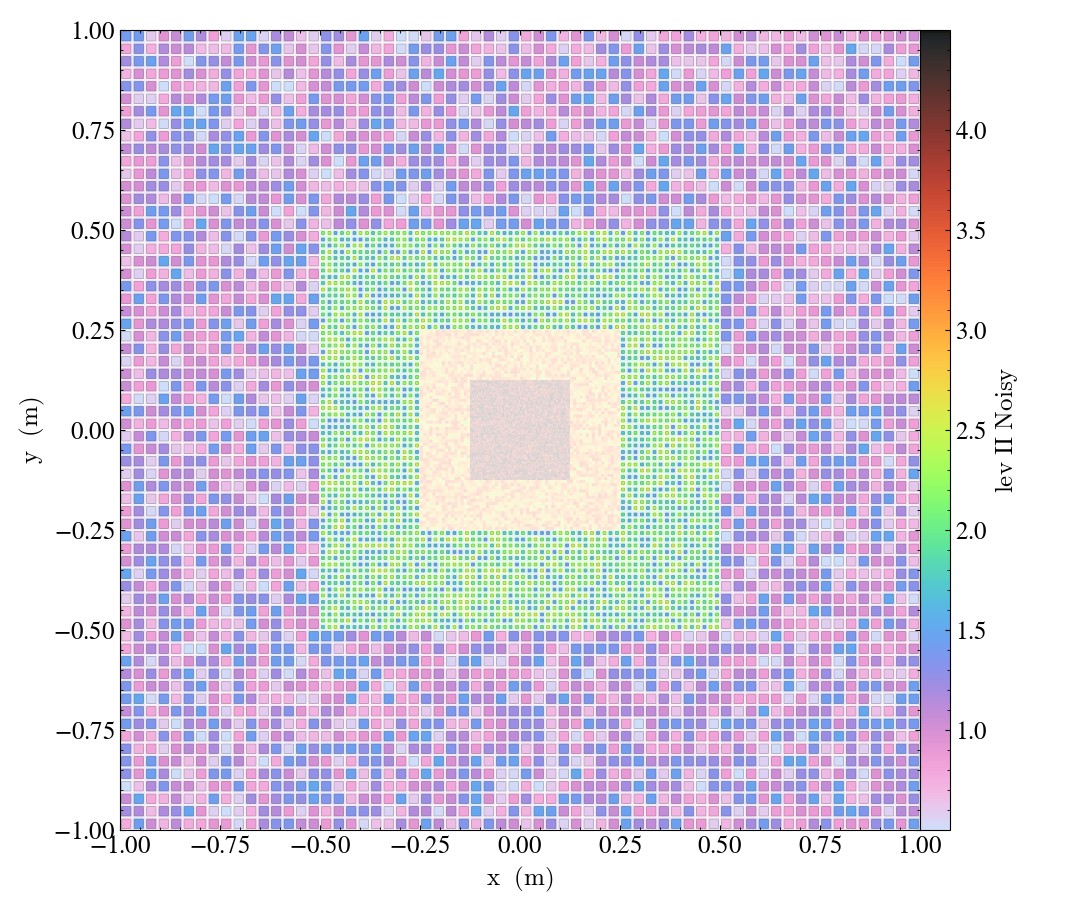

In [25]:
slc.annotate_cell_edges(color=(1., 1., 1.), alpha= 0.8)
slc


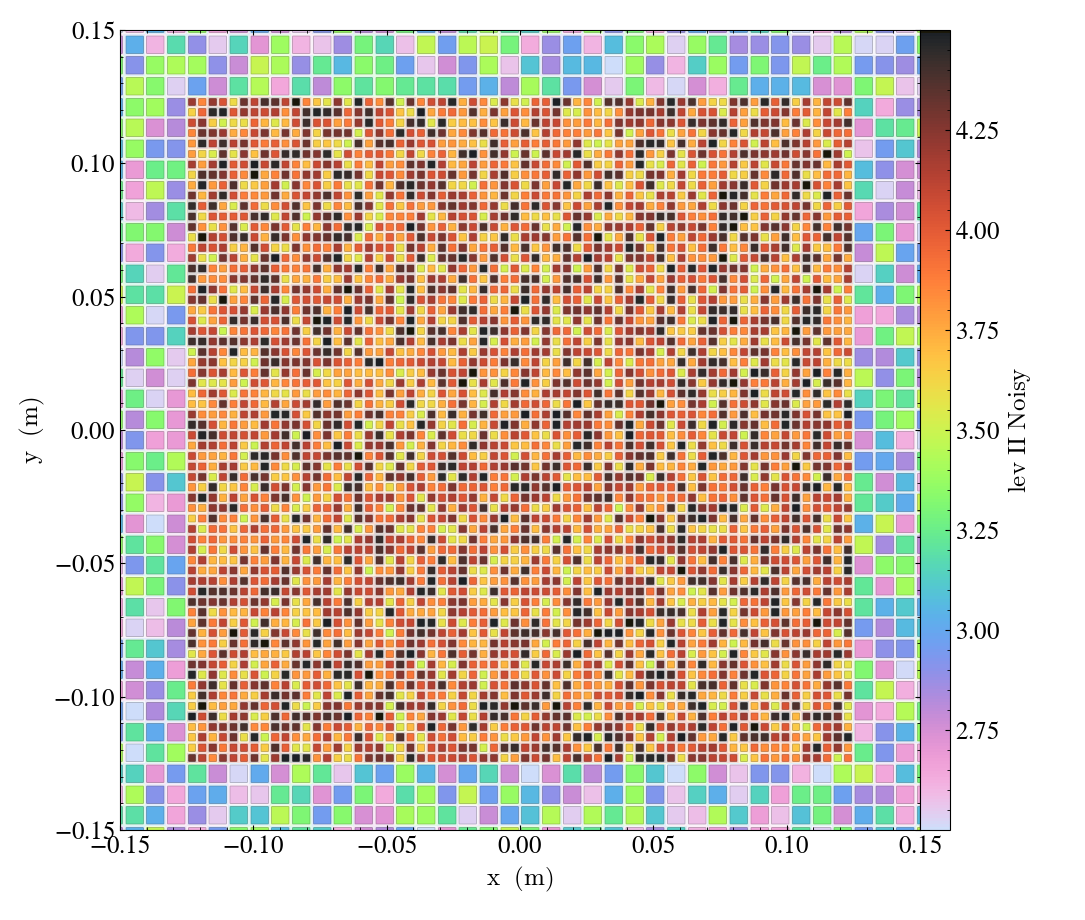

In [26]:
slc.set_width(0.3, 'm')

remember our loading from functions?

```python
    grid = {
        "left_edge": le_i,
        "right_edge": re_i,
        "dimensions": sz_i,
        "level": lev,
        ("stream", "lev_p1_noisy"): levp1_noisy,
        ("stream", "lev_p1"): levp1,
    }
```

**COULD BE**

```python
    grid = {
        "left_edge": le_i,
        "right_edge": re_i,
        "dimensions": sz_i,
        "level": lev,
        ("stream", "lev_p1_noisy"): load_from_file,
        ("stream", "lev_p1"): load_from_file,
    }
```    

where `load_from_file` is a function handle for loading a field from a file. 